In [729]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
import datetime
import holidays

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

In [730]:
import warnings
warnings.filterwarnings('ignore')

In [731]:
'2018-01-01' in hk_holidays

True

In [732]:
def extract_date(df, column):
    df[column+"_year"] = df[column].apply(lambda x: x.year)
    df[column+"_month"] = df[column].apply(lambda x: x.month)
    df[column+"_day"] = df[column].apply(lambda x: x.day)
    df[column+"_weekday"] = df[column].apply(lambda x: x.weekday())
    df[column+"_hour"] = df[column].apply(lambda x: x.hour)
    df[column+"_quarter"] = df[column].apply(lambda x: x.quarter)
    df[column+"_weekofyear"] = df[column].apply(lambda x: x.weekofyear)
    df[column+"_dayofyear"] = df[column].apply(lambda x: x.dayofyear)
    

In [733]:
hk_holidays = holidays.CountryHoliday('HK')
hour_section = {"0": 4, "1": 1, "2": 1, "3": 1, "4": 1, "5": 1, "6": 1, "7": 2, "8": 2, "9": 2, "10": 2, "11": 2, "12": 2, 
                                "13": 3, "14": 3, "15": 3, "16": 3, "17": 3, "18": 3, "19": 4, "20": 4, "21": 4, "22": 4, "23": 4 }
work_hour = {"0": 1, "1": 1, "2": 1, "3": 1, "4": 1, "5": 1, "6": 1, "7": 1, "8": 0, "9": 0, "10": 0, "11": 0, "12": 0, 
                                "13": 0, "14": 0, "15": 0, "16": 0, "17": 0, "18": 0, "19": 1, "20": 1, "21": 1, "22": 1, "23": 1 }
def data_preprocess(target_df):
    extract_date(target_df, 'date')
    target_df["a/pm"] = target_df['date_hour'].apply(lambda x : 1 if x > 11 else 0)
    target_df["hour_section"] = target_df['date_hour'].apply(lambda x : hour_section[str(x)])
    target_df["work_hour"] = target_df['date_hour'].apply(lambda x : hour_section[str(x)])
    target_df["holiday"]  = target_df['date'].apply(lambda x : 1 if x in hk_holidays or x.weekday() == 6 else 0)
    return target_df

In [734]:
'2017-01-02' in hk_holidays

True

In [735]:
def writeResultFile(preResult, col, indexName, path):
    result_df = pd.DataFrame(preResult, columns = [col])
    print(result_df.head(1))
    if indexName != '':
            result_df.index.name = indexName
    result_df.to_csv(path)

In [736]:
def writeDataFrameFile(targetDf, indexName, path):
    result_df = targetDf
    print(result_df.head(1))
    if indexName != '':
            result_df.index.name = indexName
    result_df.to_csv(path)

In [737]:
train_path = "./data/train.csv"
parser = lambda date: pd.datetime.strptime(date, '%d/%m/%Y %H:%M')
df = pd.read_csv(train_path, parse_dates = ["date"], date_parser=parser)
train_df = df[{"id","date"}]
y = df["speed"].apply(lambda x: int(x))


In [738]:
df.head(1)

,id,date,speed
0,0,2017-01-01,43.00293


In [739]:
df_preprocess = data_preprocess(df)
inputPath = "./data/df_preprocess.csv"
writeDataFrameFile(df_preprocess, '', inputPath)


   id       date     speed  date_year  date_month  date_day  date_weekday  \
0   0 2017-01-01  43.00293       2017           1         1             6   

   date_hour  date_quarter  date_weekofyear  date_dayofyear  a/pm  \
0          0             1               52               1     0   

   hour_section  work_hour  holiday  
0             4          4        1  


In [740]:
df_preprocess.head(5)

,id,date,speed,date_year,date_month,date_day,date_weekday,date_hour,date_quarter,date_weekofyear,date_dayofyear,a/pm,hour_section,work_hour,holiday
0,0,2017-01-01 00:00:00,43.002930,2017,1,1,6,0,1,52,1,0,4,4,1
1,1,2017-01-01 01:00:00,46.118696,2017,1,1,6,1,1,52,1,0,1,1,1
2,2,2017-01-01 02:00:00,44.294158,2017,1,1,6,2,1,52,1,0,1,1,1
3,3,2017-01-01 03:00:00,41.067468,2017,1,1,6,3,1,52,1,0,1,1,1
4,4,2017-01-01 04:00:00,46.448653,2017,1,1,6,4,1,52,1,0,1,1,1


In [741]:
df["speed"]

0        43.002930
1        46.118696
2        44.294158
3        41.067468
4        46.448653
           ...    
14001    19.865269
14002    17.820375
14003    12.501851
14004    15.979319
14005    40.594183
Name: speed, Length: 14006, dtype: float64

In [742]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006 entries, 0 to 14005
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   id      14006 non-null  int64         
 1   date    14006 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 219.0 KB


In [743]:
train_df = data_preprocess(train_df)

In [744]:
train_df.head(50)

,id,date,date_year,date_month,date_day,date_weekday,date_hour,date_quarter,date_weekofyear,date_dayofyear,a/pm,hour_section,work_hour,holiday
0,0,2017-01-01 00:00:00,2017,1,1,6,0,1,52,1,0,4,4,1
1,1,2017-01-01 01:00:00,2017,1,1,6,1,1,52,1,0,1,1,1
2,2,2017-01-01 02:00:00,2017,1,1,6,2,1,52,1,0,1,1,1
3,3,2017-01-01 03:00:00,2017,1,1,6,3,1,52,1,0,1,1,1
4,4,2017-01-01 04:00:00,2017,1,1,6,4,1,52,1,0,1,1,1
5,5,2017-01-01 05:00:00,2017,1,1,6,5,1,52,1,0,1,1,1
6,6,2017-01-01 06:00:00,2017,1,1,6,6,1,52,1,0,1,1,1
7,7,2017-01-01 07:00:00,2017,1,1,6,7,1,52,1,0,2,2,1
8,8,2017-01-01 08:00:00,2017,1,1,6,8,1,52,1,0,2,2,1
9,9,2017-01-01 09:00:00,2017,1,1,6,9,1,52,1,0,2,2,1


In [745]:
#train_df["a/pm"] = train_df['date_hour'].apply(lambda x : 1 if x > 11 else 0)

In [746]:
temp_df = df
temp_df = data_preprocess(train_df)
outputPath = "./output/result.csv"
temp_df.to_csv(outputPath)

In [747]:
train_df = train_df.set_index('id')

In [748]:
train_df

,date,date_year,date_month,date_day,date_weekday,date_hour,date_quarter,date_weekofyear,date_dayofyear,a/pm,hour_section,work_hour,holiday
id,,,,,,,,,,,,,
0,2017-01-01 00:00:00,2017,1,1,6,0,1,52,1,0,4,4,1
1,2017-01-01 01:00:00,2017,1,1,6,1,1,52,1,0,1,1,1
2,2017-01-01 02:00:00,2017,1,1,6,2,1,52,1,0,1,1,1
3,2017-01-01 03:00:00,2017,1,1,6,3,1,52,1,0,1,1,1
4,2017-01-01 04:00:00,2017,1,1,6,4,1,52,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14001,2018-12-31 12:00:00,2018,12,31,0,12,4,1,365,1,2,2,0
14002,2018-12-31 15:00:00,2018,12,31,0,15,4,1,365,1,3,3,0
14003,2018-12-31 16:00:00,2018,12,31,0,16,4,1,365,1,3,3,0


train_df["time"] = train_df["date"].apply(lambda x: int(x.split(" ")[1].split(":")[0]))
train_df["datetime"] = train_df["date"].apply(lambda x: x.split(" ")[0])
train_df["weekday"] = train_df["datetime"].apply(\
lambda x: datetime.datetime(int(x.split("/")[2]), int(x.split("/")[1]), int(x.split("/")[0])).weekday())
train_df

In [749]:
# load and preprocess test data
test_path = "./data/test.csv"
tdf = pd.read_csv(test_path, parse_dates = ["date"])
test_df_source = tdf[{"id","date"}]
test_df = data_preprocess(test_df_source)
test_df.head(5)

,id,date,date_year,date_month,date_day,date_weekday,date_hour,date_quarter,date_weekofyear,date_dayofyear,a/pm,hour_section,work_hour,holiday
0,0,2018-01-01 02:00:00,2018,1,1,0,2,1,1,1,0,1,1,1
1,1,2018-01-01 05:00:00,2018,1,1,0,5,1,1,1,0,1,1,1
2,2,2018-01-01 07:00:00,2018,1,1,0,7,1,1,1,0,2,2,1
3,3,2018-01-01 08:00:00,2018,1,1,0,8,1,1,1,0,2,2,1
4,4,2018-01-01 10:00:00,2018,1,1,0,10,1,1,1,0,2,2,1


In [750]:
y.head(5)

0    43
1    46
2    44
3    41
4    46
Name: speed, dtype: int64

In [751]:
y.describe()

count    14006.000000
mean        32.280380
std         13.572054
min          2.000000
25%         19.000000
50%         36.000000
75%         45.000000
max         53.000000
Name: speed, dtype: float64

# Regression

# Linear Regression

In [752]:
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from scipy.optimize import least_squares

def regression_classification(data, result, test_size, target_x, clf, path):
    #splict_index =  int(test_size*data.shape[0])
    #x_train = data[: splict_index]
    #x_test =  data[splict_index :]
    #y_train = result[: splict_index]
    #y_test =  result[splict_index :]
    x_train, x_test, y_train, y_test = train_test_split(data, result, test_size=test_size, random_state=0)
    print("x train shape: ", x_train.shape)
    print("x test shape: ", x_test.shape)
    print("y train shape: ", y_train.shape)
    print("y test shape: ", y_test.shape)
    
    clf.fit(x_train,y_train )
    score = clf.score(x_train,y_train)
    print("training score: ",score )
    y_pred =  clf.predict(x_test)
    score = mean_squared_error(y_test, y_pred)
    # The coefficients
    #print('Coefficients: \n', clf.coef_)
    # The mean squared error
    print('Mean squared error: %.2f'
          % score)
    # The coefficient of determination: 1 is perfect prediction
    print('Coefficient of determination: \n%.2f'
      % r2_score(y_test, y_pred))
    
    testdf = x_test
    testdf['predict'] = y_pred
    testdf['result'] = y_test
    test_path = "./data/test_predict_result.csv"
    writeDataFrameFile(testdf, 'id', test_path)   
    
    result = clf.predict(target_x)
    writeResultFile(result, 'speed', 'id', path)
    return score, result

In [753]:
train_df.head(1)

,date,date_year,date_month,date_day,date_weekday,date_hour,date_quarter,date_weekofyear,date_dayofyear,a/pm,hour_section,work_hour,holiday
id,,,,,,,,,,,,,
0,2017-01-01,2017,1,1,6,0,1,52,1,0,4,4,1


# Choose training parameter

In [754]:
test_size_ratio = 0.2
parameter = {"hour_section", "date_weekday", "date_hour", "a/pm", "date_day", "date_month"
                             ,"work_hour","date_year","date_quarter","date_weekofyear","date_dayofyear","holiday" }
#parameter = {"date"}
test_df = test_df_source[parameter]
x = train_df[parameter]
y = df["speed"]

In [755]:
clf = linear_model.LinearRegression()
path = "./output/lr_test_predict_result.csv"
score, result = regression_classification(x,y,test_size_ratio, test_df, clf, path)
print("Score: ",score)

x train shape:  (11204, 12)
x test shape:  (2802, 12)
y train shape:  (11204,)
y test shape:  (2802,)
training score:  0.27484619539338784
Mean squared error: 131.99
Coefficient of determination: 
0.27
     date_quarter  a/pm  date_day  date_month  hour_section  work_hour  \
id                                                                       
467             1     1        20           1             4          4   

     date_dayofyear  date_year  holiday  date_hour  date_weekofyear  \
id                                                                    
467              20       2017        0         20                3   

     date_weekday    predict     result  
id                                       
467             4  26.573762  32.717787  
       speed
0  45.597474
Score:  131.99412349443986


In [756]:
train_df.head(1)

,date,date_year,date_month,date_day,date_weekday,date_hour,date_quarter,date_weekofyear,date_dayofyear,a/pm,hour_section,work_hour,holiday
id,,,,,,,,,,,,,
0,2017-01-01,2017,1,1,6,0,1,52,1,0,4,4,1


# XGBoost

In [757]:
#parameter = {"date"}
parameter = {"hour_section", "date_weekday", "date_hour", "a/pm", "date_day", "date_month"
                             ,"work_hour","date_year","date_quarter","date_dayofyear","holiday"  }
test_df = test_df_source[parameter]
x = train_df[parameter]
y = df["speed"]

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size_ratio, random_state=0)
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

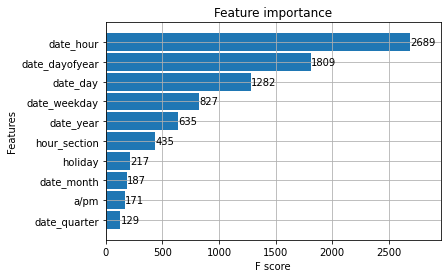

In [758]:
from xgboost import plot_importance, plot_tree
_ = plot_importance(reg, height=0.9)

In [759]:
parameter = {"hour_section", "date_weekday", "date_hour", "date_day", "date_month"
                             ,"work_hour","date_year","date_quarter","date_dayofyear","holiday"  }
#parameter = {"date"}
test_df = test_df_source[parameter]
x = train_df[parameter]
y = df["speed"]

# XGBoost
clf = xgb.XGBRegressor(n_estimators=1000)
path = "./output/xgb_predict_result.csv"
score, result = regression_classification(x,y,test_size_ratio, test_df, clf, path)
print("Score: ",score)

x train shape:  (11204, 10)
x test shape:  (2802, 10)
y train shape:  (11204,)
y test shape:  (2802,)
training score:  0.996082339810989
Mean squared error: 13.07
Coefficient of determination: 
0.93
     date_quarter  date_day  date_month  hour_section  work_hour  \
id                                                                 
467             1        20           1             4          4   

     date_dayofyear  date_year  holiday  date_hour  date_weekday    predict  \
id                                                                            
467              20       2017        0         20             4  37.319672   

        result  
id              
467  32.717787  
       speed
0  48.389606
Score:  13.071537679038261


# Xgboot cross validation & parameter  tuning

In [760]:
#parameter = {"date_weekday", "date_hour", "date_day","date_month", "date_weekofyear", "date_quarter","date_dayofyear"}
#parameter = {"date"}
test_df = test_df_source[parameter]
x = train_df[parameter]
y = df["speed"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size_ratio, random_state=0)

In [761]:
from sklearn.metrics import mean_absolute_error

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    #'objective':'reg:linear',
    'objective':'reg:squarederror',
}
num_boost_round = 999
params['eval_metric'] = "rmse"
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=50
)

[0]	Test-rmse:24.80195
Will train until Test-rmse hasn't improved in 50 rounds.
[1]	Test-rmse:17.66659
[2]	Test-rmse:12.70882
[3]	Test-rmse:9.36495
[4]	Test-rmse:7.13165
[5]	Test-rmse:5.68489
[6]	Test-rmse:4.80698
[7]	Test-rmse:4.26892
[8]	Test-rmse:3.98456
[9]	Test-rmse:3.79042
[10]	Test-rmse:3.69466
[11]	Test-rmse:3.63648
[12]	Test-rmse:3.56886
[13]	Test-rmse:3.54707
[14]	Test-rmse:3.52727
[15]	Test-rmse:3.51053
[16]	Test-rmse:3.50355
[17]	Test-rmse:3.49781
[18]	Test-rmse:3.49554
[19]	Test-rmse:3.49002
[20]	Test-rmse:3.47899
[21]	Test-rmse:3.47940
[22]	Test-rmse:3.45647
[23]	Test-rmse:3.44986
[24]	Test-rmse:3.44780
[25]	Test-rmse:3.45023
[26]	Test-rmse:3.44175
[27]	Test-rmse:3.43675
[28]	Test-rmse:3.42030
[29]	Test-rmse:3.42005
[30]	Test-rmse:3.41672
[31]	Test-rmse:3.42049
[32]	Test-rmse:3.42051
[33]	Test-rmse:3.41643
[34]	Test-rmse:3.41958
[35]	Test-rmse:3.42095
[36]	Test-rmse:3.41227
[37]	Test-rmse:3.40983
[38]	Test-rmse:3.40466
[39]	Test-rmse:3.40664
[40]	Test-rmse:3.40244
[41]	Te

In [762]:
print("Best RMSE: {:.2f} with {} rounds".format(
                 model.best_score,
                 model.best_iteration+1))

Best RMSE: 3.33 with 99 rounds


In [763]:
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,24.732881,0.038104,24.734364,0.161090
1,17.598994,0.023966,17.604981,0.114336
2,12.680749,0.023567,12.694068,0.074875
3,9.341265,0.009977,9.367106,0.062914
4,7.099974,0.009231,7.136654,0.062842
...,...,...,...,...
65,2.589644,0.014367,3.414426,0.055635
66,2.580002,0.015704,3.413444,0.055271
67,2.572199,0.016643,3.412099,0.054124
68,2.565152,0.018920,3.410693,0.052762


In [764]:
cv_results['test-rmse-mean'].min()

3.4092580000000003

In [765]:
# You can try wider intervals with a larger step between
# each value and then narrow it down. Here after several
# iteration I found that the optimal value was in the
# following ranges.
gridsearch_params = [
    (max_depth, min_child_weight)
    for max_depth in range(3,15)
    for min_child_weight in range(2,10)
]

In [766]:
# Define initial best params and MAE
min_rmse = float("Inf")
best_params = None
for max_depth, min_child_weight in gridsearch_params:
    print("CV with max_depth={}, min_child_weight={}".format(
                             max_depth,
                             min_child_weight))
    # Update our parameters
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best MAE
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (max_depth,min_child_weight)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))
params['max_depth'] = best_params[0]
params['min_child_weight'] = best_params[1]

CV with max_depth=3, min_child_weight=2
	RMSE 3.5463654 for 351 rounds
CV with max_depth=3, min_child_weight=3
	RMSE 3.529681 for 460 rounds
CV with max_depth=3, min_child_weight=4
	RMSE 3.5380674 for 359 rounds
CV with max_depth=3, min_child_weight=5
	RMSE 3.5857175999999997 for 193 rounds
CV with max_depth=3, min_child_weight=6
	RMSE 3.5463426000000005 for 339 rounds
CV with max_depth=3, min_child_weight=7
	RMSE 3.5242484 for 485 rounds
CV with max_depth=3, min_child_weight=8
	RMSE 3.5495922 for 318 rounds
CV with max_depth=3, min_child_weight=9
	RMSE 3.530292 for 384 rounds
CV with max_depth=4, min_child_weight=2
	RMSE 3.4612803999999997 for 191 rounds
CV with max_depth=4, min_child_weight=3
	RMSE 3.4485038 for 223 rounds
CV with max_depth=4, min_child_weight=4
	RMSE 3.4568898 for 188 rounds
CV with max_depth=4, min_child_weight=5
	RMSE 3.4469196 for 240 rounds
CV with max_depth=4, min_child_weight=6
	RMSE 3.4501152000000004 for 197 rounds
CV with max_depth=4, min_child_weight=7
	RM

In [767]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(5,11)]
    for colsample in [i/10. for i in range(5,11)]
]

In [768]:
min_rmse = float("Inf")
best_params = None
# We start by the largest values and go down to the smallest
for subsample, colsample in reversed(gridsearch_params):
    print("CV with subsample={}, colsample={}".format(
                             subsample,
                             colsample))
    # We update our parameters
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    # Run CV
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics={'rmse'},
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = (subsample,colsample)
print("Best params: {}, {}, RMSE: {}".format(best_params[0], best_params[1], min_rmse))
params['subsample'] = best_params[0]
params['colsample_bytree'] = best_params[1]

CV with subsample=1.0, colsample=1.0
	RMSE 3.356488 for 69 rounds
CV with subsample=1.0, colsample=0.9
	RMSE 3.3844792 for 54 rounds
CV with subsample=1.0, colsample=0.8
	RMSE 3.4016695999999995 for 59 rounds
CV with subsample=1.0, colsample=0.7
	RMSE 3.4095938000000006 for 80 rounds
CV with subsample=1.0, colsample=0.6
	RMSE 3.4262382000000002 for 63 rounds
CV with subsample=1.0, colsample=0.5
	RMSE 3.443284 for 103 rounds
CV with subsample=0.9, colsample=1.0
	RMSE 3.3846602 for 48 rounds
CV with subsample=0.9, colsample=0.9
	RMSE 3.4035382000000007 for 48 rounds
CV with subsample=0.9, colsample=0.8
	RMSE 3.4152044000000004 for 88 rounds
CV with subsample=0.9, colsample=0.7
	RMSE 3.4132568 for 61 rounds
CV with subsample=0.9, colsample=0.6
	RMSE 3.43544 for 63 rounds
CV with subsample=0.9, colsample=0.5
	RMSE 3.4566998 for 77 rounds
CV with subsample=0.8, colsample=1.0
	RMSE 3.38904 for 50 rounds
CV with subsample=0.8, colsample=0.9
	RMSE 3.4179204 for 39 rounds
CV with subsample=0.8,

In [769]:
%time
# This can take some time…
min_rmse = float("Inf")
best_params = None
for eta in [.5, .4, .3, .2, .1, .05, .01, .005]:
    print("CV with eta={}".format(eta))
    # We update our parameters
    params['eta'] = eta
    # Run and time CV    
    cv_results = xgb.cv(
        params,
        dtrain,
        num_boost_round=num_boost_round,
        seed=42,
        nfold=5,
        metrics=['rmse'],
        early_stopping_rounds=10
    )
    # Update best score
    mean_rmse = cv_results['test-rmse-mean'].min()
    boost_rounds = cv_results['test-rmse-mean'].argmin()
    print("\tRMSE {} for {} rounds\n".format(mean_rmse, boost_rounds))
    if mean_rmse < min_rmse:
        min_rmse = mean_rmse
        best_params = eta
print("Best params: {}, RMSE: {}".format(best_params, min_rmse))
params['eta'] = best_params

Wall time: 0 ns
CV with eta=0.5
	RMSE 3.4501252 for 28 rounds

CV with eta=0.4
	RMSE 3.3953128 for 44 rounds

CV with eta=0.3
	RMSE 3.356488 for 69 rounds

CV with eta=0.2
	RMSE 3.3671178 for 96 rounds

CV with eta=0.1
	RMSE 3.3598954 for 193 rounds

CV with eta=0.05
	RMSE 3.3512312 for 386 rounds

CV with eta=0.01
	RMSE 3.3944099999999997 for 998 rounds

CV with eta=0.005
	RMSE 3.5137586 for 998 rounds

Best params: 0.05, RMSE: 3.3512312


In [770]:
params

{'max_depth': 7,
 'min_child_weight': 3,
 'eta': 0.05,
 'subsample': 1.0,
 'colsample_bytree': 1.0,
 'objective': 'reg:squarederror',
 'eval_metric': 'rmse'}

In [771]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[0]	Test-rmse:33.36431
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:31.73056
[2]	Test-rmse:30.17765
[3]	Test-rmse:28.70345
[4]	Test-rmse:27.30353
[5]	Test-rmse:25.97618
[6]	Test-rmse:24.71449
[7]	Test-rmse:23.51908
[8]	Test-rmse:22.38346
[9]	Test-rmse:21.30403
[10]	Test-rmse:20.28139
[11]	Test-rmse:19.31271
[12]	Test-rmse:18.39315
[13]	Test-rmse:17.52179
[14]	Test-rmse:16.69615
[15]	Test-rmse:15.91080
[16]	Test-rmse:15.16892
[17]	Test-rmse:14.46532
[18]	Test-rmse:13.79931
[19]	Test-rmse:13.16650
[20]	Test-rmse:12.57075
[21]	Test-rmse:12.00658
[22]	Test-rmse:11.47086
[23]	Test-rmse:10.96490
[24]	Test-rmse:10.48561
[25]	Test-rmse:10.03161
[26]	Test-rmse:9.60466
[27]	Test-rmse:9.20182
[28]	Test-rmse:8.82189
[29]	Test-rmse:8.46460
[30]	Test-rmse:8.12773
[31]	Test-rmse:7.80990
[32]	Test-rmse:7.51239
[33]	Test-rmse:7.23176
[34]	Test-rmse:6.97060
[35]	Test-rmse:6.72582
[36]	Test-rmse:6.49314
[37]	Test-rmse:6.27698
[38]	Test-rmse:6.07268
[39]	Test-rmse:5.88510
[40]	Te

In [772]:
num_boost_round = model.best_iteration + 1
params["n_estimators"] = 1000
best_model = xgb.XGBRegressor(max_depth=params["max_depth"], min_child_weight=params["min_child_weight"],
                                                                  learning_rate=params["eta"], subsample=params['subsample'],colsample_bytree=params['colsample_bytree'],
                                                                  n_estimators=params["n_estimators"] , objective=params["objective"])
best_model.fit(x_train, y_train,
        eval_set=[(x_train, y_train), (x_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=7,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

best_model  = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
)

In [773]:
print('Mean squared error: %.2f'
      % mean_squared_error(best_model.predict(x_test), y_test))

Mean squared error: 11.01


In [774]:
# use fine tun model for predictiing the model
xgb_result = best_model.predict(test_df)
path = "./output/xgb_best_test_predict_result.csv"
writeResultFile(xgb_result, 'speed', 'id', path)

       speed
0  47.971939


In [775]:
best_model.save_model("my_model.model")

In [776]:
loaded_model = xgb.Booster()
loaded_model.load_model("my_model.model")

In [777]:
loaded_model.predict(dtest)

array([33.49365 , 48.253475, 23.097866, ..., 15.224529, 38.264088,
       47.779297], dtype=float32)

# Grid Search CV

In [778]:
test_df_source.head(1)

,id,date,date_year,date_month,date_day,date_weekday,date_hour,date_quarter,date_weekofyear,date_dayofyear,a/pm,hour_section,work_hour,holiday
0,0,2018-01-01 02:00:00,2018,1,1,0,2,1,1,1,0,1,1,1


# parameter = {"hour_section", "date_weekday", "date_hour", 'date_day'}
#parameter = {"date"}
test_df = test_df_source[parameter]
x = train_df[parameter]
y = df["speed"]

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size_ratio, random_state=0)
# A parameter grid for XGBoost

params = {'min_child_weight':[1,10], 
                      'gamma':[i/10.0 for i in range(1,10)],  
                      'subsample':[i/10.0 for i in range(3,11)],
                     'colsample_bytree':[i/10.0 for i in range(3,11)], 
                      'max_depth': [1,2,3,4,5]}
# Initialize XGB and GridSearch
xgb_clf = xgb.XGBRegressor(nthread=-1) 
grid = GridSearchCV(xgb_clf, params)
grid.fit(x_train, y_train)

# Print the mean_squared_error score
print(mean_squared_error(y_test, grid.best_estimator_.predict(x_test))) 

# Save the file
y_predict = grid.best_estimator_.predict(test_df)
results_df = pd.DataFrame(data={'speed':y_predict}) 
path = "./output/xgb_grid_test_predict_result.csv"
writeDataFrameFile(results_df, 'id', path)

# Parameter selection

test_df_source.head(1)

parameter = {"hour_section", "date_weekday", "date_hour", "date_day","date_month","a/pm"}
#parameter = {"date"}
test_df = test_df_source[parameter]
x = train_df[parameter]
y = df["speed"]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=0)

params = {
    # Parameters that we are going to tune.
    'max_depth':6,
    'min_child_weight': 1,
    'eta':.3,
    'subsample': 1,
    'colsample_bytree': 1,
    # Other parameters
    #'objective':'reg:linear',
    'objective':'reg:squarederror',
}
num_boost_round = 999
params['eval_metric'] = "rmse"
params['eta'] = 0.2
params['subsample'] = 1.0
params['colsample_bytree'] = 0.9
params['max_depth'] = 4
params['min_child_weight'] = 2

In [779]:
dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)
cv_results = xgb.cv(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    seed=42,
    nfold=5,
    metrics={'rmse'},
    early_stopping_rounds=10
)
cv_results

[22:10:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:10:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:10:20] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in la

,train-rmse-mean,train-rmse-std,test-rmse-mean,test-rmse-std
0,33.279204,0.052953,33.279313,0.211503
1,31.645758,0.050028,31.645852,0.201585
2,30.094956,0.047120,30.095610,0.192148
3,28.622946,0.044522,28.624431,0.182536
4,27.225359,0.042081,27.226986,0.174313
...,...,...,...,...
245,2.639577,0.017722,3.371386,0.047605
246,2.636424,0.018027,3.370843,0.047708
247,2.634598,0.017952,3.370761,0.047846
248,2.631968,0.018514,3.370296,0.047770


In [780]:
model = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
    early_stopping_rounds=10
)

[22:10:22] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-rmse:33.36431
Will train until Test-rmse hasn't improved in 10 rounds.
[1]	Test-rmse:31.73056
[2]	Test-rmse:30.17765
[3]	Test-rmse:28.70345
[4]	Test-rmse:27.30353
[5]	Test-rmse:25.97618
[6]	Test-rmse:24.71449
[7]	Test-rmse:23.51908
[8]	Test-rmse:22.38346
[9]	Test-rmse:21.30403
[10]	Test-rmse:20.28139
[11]	Test-rmse:19.31271
[12]	Test-rmse:18.39315
[13]	Test-rmse:17.52179
[14]	Test-rmse:16.69615
[15]	Test-rmse:15.91080
[16]	Test-rmse:15.16892
[17]	Test-rmse:14.46532
[18]	Test-rmse:13.79931
[19]	Test-rmse:13.16650
[20]	Test-rmse:12.57075
[21]	Test-rmse:12.00658
[22]	Test-rmse:11.47086
[23]	Test-r

In [781]:
num_boost_round = model.best_iteration + 1
best_model  = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=[(dtest, "Test")],
)


[22:10:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	Test-rmse:33.36431
[1]	Test-rmse:31.73056
[2]	Test-rmse:30.17765
[3]	Test-rmse:28.70345
[4]	Test-rmse:27.30353
[5]	Test-rmse:25.97618
[6]	Test-rmse:24.71449
[7]	Test-rmse:23.51908
[8]	Test-rmse:22.38346
[9]	Test-rmse:21.30403
[10]	Test-rmse:20.28139
[11]	Test-rmse:19.31271
[12]	Test-rmse:18.39315
[13]	Test-rmse:17.52179
[14]	Test-rmse:16.69615
[15]	Test-rmse:15.91080
[16]	Test-rmse:15.16892
[17]	Test-rmse:14.46532
[18]	Test-rmse:13.79931
[19]	Test-rmse:13.16650
[20]	Test-rmse:12.57075
[21]	Test-rmse:12.00658
[22]	Test-rmse:11.47086
[23]	Test-rmse:10.96490
[24]	Test-rmse:10.48561
[25]	Test-rmse:10.03

In [782]:
print('Mean squared error: %.2f'
      % mean_squared_error(best_model.predict(dtest), y_test))

Mean squared error: 11.24
